# Data Exploration

In this notebook we explore the data in order to better understand it and to get information that will help to guide model choice.

In [1]:
import os
import numpy as np

np.random.seed(30) # fix random seed
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # fix cuda device to be used

## Read data, standardize, and separate into train/valid

from helpers import read_and_preprocess_data

train, valid = read_and_preprocess_data()

Data read. There are 96 series in total.


## Begin data exploration

Check the average and total series length.

In [10]:
len_ = 0
count = 0
for x,y in train:
    len_ += len(x)
    count += 1
print("Average series length: {}".format(len_/count))
print("Sum of all series length: {}".format(len_))

Average series length: 187071
Sum of all series length: 15714003


## Visualizing one repetition

In the figure below, we are going to plot how each label evolve over time for one repetition of the grasp-and-lift movement.

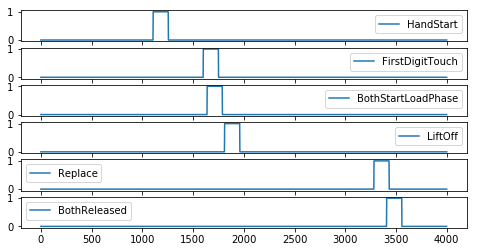

In [11]:
fig = plt.figure(figsize=(8,4))
cols = train[0][1].columns
first_ax = None

for idx,col in enumerate(cols):
    if first_ax == None:
        ax = fig.add_subplot(len(cols),1,idx+1)
        first_ax = ax
    else: 
        ax = fig.add_subplot(len(cols),1,idx+1, sharex=first_ax)
    ax.plot(train[33][1].reset_index()[col][:4000], label=col)
    ax.legend()

From the plot above, we can see that there is some overlapping of labels, specially for the "FirstDigitTouch", "BothStartLoadPhase" and "LiftOff" labels. Therefore, we must NOT apply a softmax function at our outputs, but a sigmoid instead. In other words, it is not only a *multi-class classification* problem, but a *multi-label classification* one.

## Check step duration

From the last plot, we also see that each label tend to be classified as true for the same time period. We are going to check whether this is true and the average step duration.

In [12]:
last = {}
step_start = {}
step_duration = {}
step_count = {}
y_cols = train[0][1].columns
for col in y_cols:
    step_start[col] = 0
    step_duration[col] = 0
    step_count[col] = 0
    
for _,y in [train[0]]:
    for idx,row in y.reset_index().iterrows():
        for col in y_cols:
            if idx == 0:
                pass
            elif last[col] == 0 and row[col] == 1:
                step_start[col] = idx
            elif last[col] == 1 and row[col] == 0:
                step_duration[col] += idx - step_start[col]
                step_count[col] += 1
            last[col] = row[col]

step_avg_duration = {}
for col in y_cols:
    step_avg_duration[col] = step_duration[col] / step_count[col]

print step_avg_duration

{'HandStart': 150, 'LiftOff': 150, 'Replace': 150, 'BothStartLoadPhase': 150, 'FirstDigitTouch': 150, 'BothReleased': 150}


The duration of each step (the total amount of time each movement is active) is 150 for all series. We can use this information to guide our search for the best window size (WS). A WS smaller than 150 is likely to miss important information that would help to identify an ongoing movement. WSs much bigger than that are likely to fill the model with unnecessary information (increasing variance). Thus, we expect to experiment with WSs ranging from 150 to 1500.